In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [8]:
# Method for preprocessing the training set
def preprocessor_training(image, label):
    image_cropped = tf.image.random_crop(image, size=(178, 178, 3))
    image_resized = tf.image.resize(image_cropped, size=(64, 64))
    image_flip = tf.image.random_flip_left_right(image_resized)

    return image_flip / 255.0, label

In [9]:
# Method for preprocessing the validation and test sets
def preprocessor_evaluation(image, label):
    image_cropped = tf.image.crop_to_bounding_box(image, offset_height=20, offset_width=0, target_height=178, target_width=178)
    image_resized = tf.image.resize(image_cropped, size=(64, 64))

    return image_resized / 255.0, label

In [2]:
# Get the output labels and store them as a list
attributes_dir = os.getcwd() + "\list_attr_celeba.csv"
attributes = pd.read_csv(attributes_dir)

# Change the output labels to be (0, 1)
attributes['Male'] = attributes['Male'].replace(-1, 0)
gender = attributes[['Male']]
output_labels = gender['Male'].tolist()

In [13]:
# Download the image dataset and separate it into training and validation sets
img_dir = os.getcwd() + "\img_align_celeba"
img_size = (218, 178)

celeba_train, celeba_extras = tf.keras.utils.image_dataset_from_directory(img_dir, labels=output_labels, label_mode='binary', batch_size=None, image_size=img_size, validation_split=0.2, shuffle=False, subset='both')

Found 202599 files belonging to 2 classes.
Using 162080 files for training.
Using 40519 files for validation.


In [14]:
# Split the extras into the validation and testing sets
celeba_train = celeba_train.take(16000)
celeba_extras = celeba_extras.take(2000)
celeba_valid = celeba_extras.take(1000)
celeba_test = celeba_extras.skip(1000)

In [15]:
# Process the training and valdiation sets for the CNN model
BATCH_SIZE = 32
BUFFER_SIZE = 1000
steps_per_epoch = np.ceil(16000 / BATCH_SIZE)

celeba_train = celeba_train.map(preprocessor_training)
celeba_train = celeba_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
celeba_train = celeba_train.batch(BATCH_SIZE)

celeba_valid = celeba_valid.map(preprocessor_evaluation)
celeba_valid = celeba_valid.batch(BATCH_SIZE)

In [19]:
# Create the CNN
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation=None)
])

In [20]:
# Compile the model and view its summary
tf.random.set_seed(1)

model.build(input_shape=(None, 64, 64, 3))
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 64, 64, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 32, 32, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 388,673 (1.48 MB)

 Trainable params: 388,673 (1.48 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the model
history = model.fit(celeba_train, validation_data=celeba_valid, epochs=20, steps_per_epoch=int(steps_per_epoch))

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 66s 125ms/step - accuracy: 0.5816 - loss: 0.6836 - val_accuracy: 0.6660 - val_loss: 0.5676
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 80ms/step - accuracy: 0.6912 - loss: 0.5620 - val_accuracy: 0.7580 - val_loss: 0.4586
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 83ms/step - accuracy: 0.7455 - loss: 0.4941 - val_accuracy: 0.7290 - val_loss: 0.4453
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 81ms/step - accuracy: 0.7733 - loss: 0.4546 - val_accuracy: 0.8140 - val_loss: 0.3822
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.7928 - loss: 0.4307 - val_accuracy: 0.8020 - val_loss: 0.3620
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 39s 78ms/step - accuracy: 0.8156 - loss: 0.3819 - val_accuracy: 0.8380 - val_loss: 0.2934
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 42s 84ms/step - accuracy: 0.8512 - loss: 0.3190 - val_accuracy: 0.8840 - val_loss: 0.2129
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 86ms/step - accuracy: 0.8697 - loss: 0.2822 -

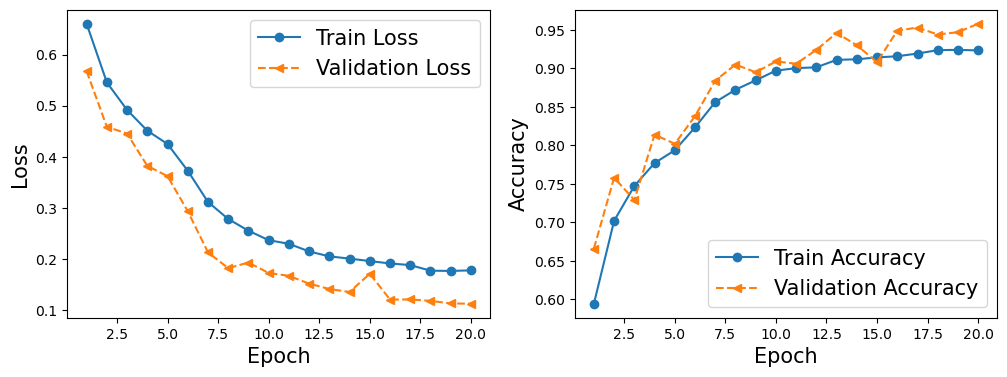

In [22]:
# Plot the graphs of the CNN's loss and accuracy scores
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label="Train Loss")
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Accuracy')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [23]:
# Train the model further
history = model.fit(celeba_train, validation_data=celeba_valid, epochs=40, initial_epoch=20, steps_per_epoch=int(steps_per_epoch))

Epoch 21/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 101ms/step - accuracy: 0.9309 - loss: 0.1655 - val_accuracy: 0.9340 - val_loss: 0.1371
Epoch 22/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 104ms/step - accuracy: 0.9307 - loss: 0.1643 - val_accuracy: 0.9560 - val_loss: 0.1140
Epoch 23/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step - accuracy: 0.9347 - loss: 0.1553 - val_accuracy: 0.9380 - val_loss: 0.1296
Epoch 24/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 51s 102ms/step - accuracy: 0.9326 - loss: 0.1570 - val_accuracy: 0.9570 - val_loss: 0.1087
Epoch 25/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 50s 101ms/step - accuracy: 0.9355 - loss: 0.1555 - val_accuracy: 0.9620 - val_loss: 0.1027
Epoch 26/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 54s 107ms/step - accuracy: 0.9353 - loss: 0.1524 - val_accuracy: 0.9570 - val_loss: 0.1041
Epoch 27/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 53s 106ms/step - accuracy: 0.9347 - loss: 0.1537 - val_accuracy: 0.9450 - val_loss: 0.1172
Epoch 28/40
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.9371 - 

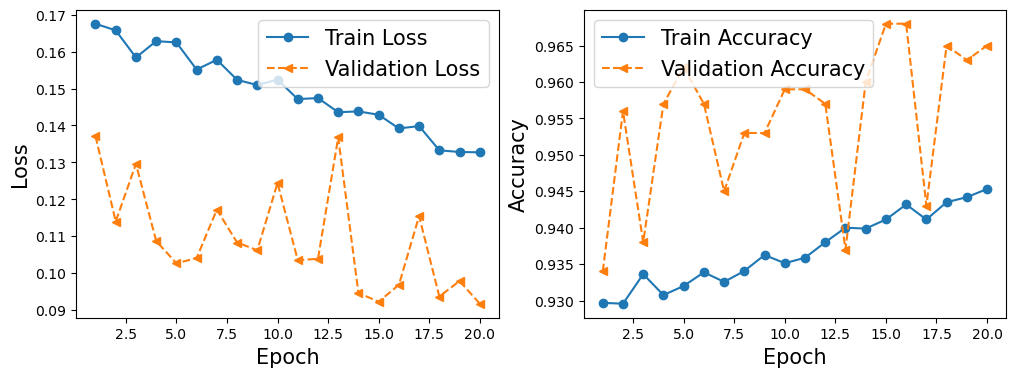

In [24]:
# Plot the graphs of the CNN's loss and accuracy scores
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist['loss'], '-o', label="Train Loss")
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Accuracy')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Accuracy')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [26]:
# Process the testing set
celeba_test = celeba_test.map(preprocessor_evaluation)

In [27]:
# Evalaute the accuracy of the CNN model
celeba_test = celeba_test.batch(32)
test_results = model.evaluate(celeba_test)
print('Testing Accuracy: {:.2f}%'.format(test_results[1] * 100))

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.9455 - loss: 0.1158
Testing Accuracy: 94.70%


In [29]:
# Collect predictions on a sample batch from the testing set
batch_test = celeba_test.unbatch().take(10)
pred_logits = model.predict(batch_test.batch(10))
probas = tf.sigmoid(pred_logits)
probas = probas.numpy().flatten() * 100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step


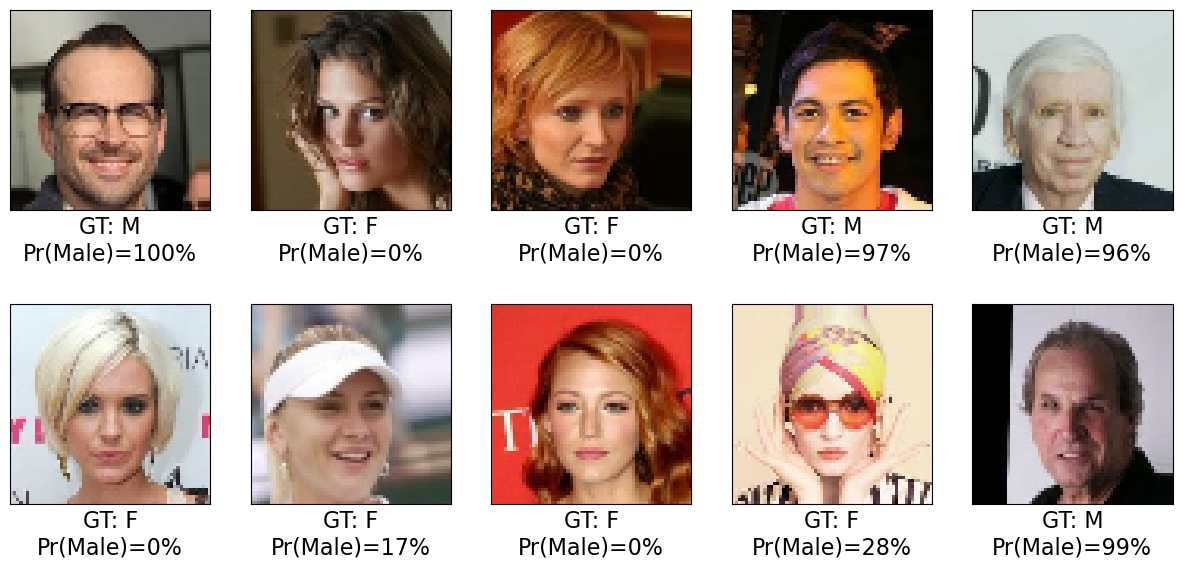

In [31]:
# Display the sample set with the model's predictions
fig = plt.figure(figsize=(15, 7))

for j, example in enumerate(batch_test):
    ax = fig.add_subplot(2, 5, j+1)
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(example[0])
    
    if example[1].numpy() == 1: label = 'M'
    else: label = 'F'
    
    ax.text(0.5, -0.15, 'GT: {:s}\nPr(Male)={:.0f}%'''.format(label, probas[j]), size=16, horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

plt.show()